### Description
In this notebook we use the Bayesian ResNet to get mutual information and softmax variance estimates which are then used in another notebook for comparison between MI, SV and LID.
We get the scores for a specific subset of 1000 CIFAR test images. Those have been used before to estimate LID scores.

In [ ]:
import sys
from timeit import default_timer as timer
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

import keras

from evaluator import visualization as vis
from evaluator import defense
from evaluator.models.resnet import Resnet
from evaluator.models.model import CarliniCifarWrapper, RobustModel
from evaluator.dataset import CIFAR
from evaluator.utils import merge_and_generate_labels
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

In [2]:
ims = np.array([5912,  294, 2259, 6525, 7310, 9368,  471, 8165, 9943,  196, 1665,
       3823, 1661, 5931, 6764,  731, 6900, 2051, 4453, 1522, 4419, 9533,
       9647, 7745, 1595, 4098, 7724, 1146, 1159, 8872, 5141, 2597, 6481,
       1583, 3202, 5360,  430, 6366, 9537, 3230, 1607, 9229, 7475, 4716,
       4956, 7942, 5330, 3398, 7138, 4160, 2695, 6934, 1157, 2162, 2151,
       3876, 5745, 3749, 4967, 3158, 3222, 1109, 7311, 3991,  916, 7787,
       2132,  120, 7133, 3490, 1428,  232, 1678, 8288, 5489, 7042, 9743,
       4576, 1961, 5544, 6316, 1048, 1116, 6269, 6962, 6138, 8401, 7577,
       3144, 7017, 8390, 5943, 2963, 1735,   62, 7175, 8431, 5929, 3317,
       8630,  447, 3085, 5846, 4184, 8576, 1069, 3622, 1978, 1895, 4086,
        910, 9465, 8471, 5595, 1313, 8121,  473, 9657, 5227,  446,   10,
       7662, 8410, 1918, 2529, 8700, 8492, 4396, 5374, 4218, 4172, 1693,
       3701, 2476, 6023, 3231, 6567,  909, 2620, 9758,  762, 5408, 9809,
       7852, 7762, 3574,    0, 7103, 6237, 4136, 8174, 3556, 3931, 8807,
       3867, 3642, 7408, 7252, 3551, 6668, 9004, 3351, 4418, 5443, 3049,
       9119, 4448, 7084, 2354, 2826, 8304, 7068, 4032, 8462, 6937, 4822,
       3965, 5181, 2640, 7779, 6282, 8444, 2345, 8198, 8721, 5057, 3284,
       9602, 4660, 9350, 6326,  375, 7905, 8830, 7832, 8112, 7401, 7482,
       3720, 8372, 1269, 6553, 3736, 4620, 4687, 7147, 7443, 4544, 9545,
       9687, 9348,   28, 1111, 1437,  335, 1187, 8648, 6924, 3072,  159,
       4668, 5721, 4838, 3189, 4495, 3934, 8489, 8676, 1878, 8573, 9046,
       6569,  495, 7436, 3214, 7016, 4680,  460, 5204, 9800, 5424, 6578,
       5442, 3446, 2442, 7422, 9922, 2522, 4112,  581, 4012, 4690, 3875,
       7600, 1209, 6293, 9186, 8400, 8177, 8875, 9740,   24, 4977, 9171,
       6739, 9026, 9675, 8417, 8446, 8819, 4483, 9543, 6767, 6977, 8137,
       6406, 4433, 5400, 3028, 3677, 7259, 5796, 1578, 3303, 1005, 7532,
       5157, 9317,  680, 7973, 7903, 1820, 9760, 1812, 7983, 9749,   31,
       8603, 5952, 4861, 7376, 4962, 3600, 4602,  752, 8594, 4771, 2344,
       6876, 7409, 2405, 6303, 7854, 2319,  289, 4436,  839, 7230, 5656,
       4193, 2753, 7766, 8546, 9311, 5333, 1979, 3624, 4452,  297, 7362,
       4507, 4335, 8777, 1788,  496, 2073, 5023, 4347, 2373, 5495, 7634,
        389, 6980, 5902, 6149, 6419,  838,  286, 3017, 4005,  691,  105,
       3685, 8900, 3096, 8869, 2226, 8806, 5177, 4667, 6958, 6541, 6885,
       9697, 8810, 9581,  569, 4297, 9426, 8037, 1852, 6194, 7768, 8302,
       2844, 3805, 9129, 6285, 7890, 6436, 6266, 2760, 6728, 6665,  676,
       4523, 6249, 2234, 7909, 2392, 8240,   88, 5388, 2979, 1683, 9881,
        776, 1472, 2082, 8910, 6013, 1934, 6190, 1779, 3975, 4302, 5739,
       9641,   86, 5012, 7439, 9263, 4794, 8690, 8144,  631, 1728, 1879,
       8943, 2229, 5191, 1768, 9408, 5247,  638, 8817, 9033, 2847, 2882,
       9322, 5325,  213, 1922, 2258, 3697,  449, 4731, 8650, 3566, 6135,
       9174,  781, 1004, 5771,  813, 5523, 5852,  215, 7080,  571, 8731,
       2906, 3502, 6798, 7093, 6598, 1092, 2349, 2275, 8239, 9806, 5623,
        778, 8455, 5922, 9051, 7829, 7105, 6721, 1950, 3801, 9389,  666,
       3250, 6306, 3114, 6512, 7473,  729, 4599, 8824, 2102, 5193, 8567,
       5665, 1653, 1405, 3001, 4536, 8052, 6372, 4937, 8732, 7250,   74,
       8191, 4847, 5576, 5579,  614, 6792, 4371, 7947, 5020, 4978, 4619,
       1012, 6146, 4799, 8335, 6021,  698, 5498, 3084, 7469, 4640, 5839,
       7348, 1977, 1212, 6485, 3399,  180, 1840, 3234, 5481, 8443, 9991,
       3746, 9559, 3951, 6495, 3905, 8392, 3147, 5551, 4499, 5969, 8057,
       2917, 9989, 6342, 3990, 3850, 2772, 4042, 2978, 4519, 6015, 7568,
       2338, 9726, 8066, 3460, 3349, 5600, 1786,  349, 5358, 6387, 1575,
       5515, 1042, 5432, 9409, 4379, 5072, 6124, 7957, 8925, 4638, 8511,
       1529,  854, 5308, 1908, 6702, 7295, 6987, 6735, 6003, 5257, 3548,
       8051, 6809, 5897, 7300, 1455, 6844, 4784, 9003, 7052, 4191, 4922,
       6676, 8363, 5065, 9725, 2790, 3942, 9979, 9181, 3335, 8550, 2101,
        735, 2731, 3082, 1535, 6782,  489, 6871, 3205, 3617, 9512, 4849,
       4780, 4872, 8215, 7614, 1859,  250, 4547, 4398, 4424,  575, 4747,
       6166, 2900, 7141, 5938, 9440, 9718, 2795, 4439, 1023, 3295, 3764,
       3567, 1881,  361, 2684, 8203, 9015,  203, 3846, 7155, 9236, 9381,
       9654, 9222,  462, 4230, 6468, 8141, 6907, 7123, 3737, 4316, 3150,
        253, 8748, 5304, 8649, 6004, 8357, 8176, 2953, 8998, 1284, 5410,
       8874, 3695, 5919, 6183, 4457, 3119, 9966, 6666, 2994, 5601,  540,
       5021, 3878, 3626, 8095, 5431, 5096, 3785, 3517, 8424, 2602, 3058,
       9819,    2, 6609, 4240, 8617,  811,  587, 1681, 2334, 3668,  586,
        204, 4303, 6420, 3860, 5182, 5364, 1563, 9062, 1454, 4598, 4497,
       2219, 4992, 7526, 4102, 8345, 4670, 8672, 6580, 9391, 4512, 3170,
       4762, 4362, 5979,   77, 3038, 5328,  406, 8113, 4210, 8525, 8581,
       1952, 9509, 7456, 8339,   41, 4021, 1418, 9980,   47, 8290, 5094,
       8347, 9591, 2403, 6555, 4173, 5868, 3291, 2537, 9579, 9157, 7566,
       4156, 9137, 3126, 1832, 8849, 1914, 5078, 9738, 9067, 2227, 6828,
       2488, 5686, 1645, 2415, 2968, 6652, 1121, 2150,  951, 5925, 2370,
       4363, 4121, 9767, 4384, 3107,   15, 5907,  345, 3153, 6408, 4405,
       4793, 4931, 1723, 8194, 2920, 8101, 6428, 7740, 5836, 6189, 4592,
       2312, 2220, 9812, 6049, 1340, 7590, 7751, 4444, 7710, 8267, 5392,
       1545, 2947, 2195, 6613, 4947, 1489, 5246, 5032, 7726, 5647, 7889,
       7962, 2971,  308, 1619, 9532, 2570, 5479, 9246, 5905, 2071, 9172,
        563, 2598, 2040, 5539, 4500, 7194, 8687, 5816, 7021, 8227, 8224,
       3066,  488,  415,  779, 2369, 6204, 7620, 2348, 6310, 7355, 9706,
       2634, 2577, 7703, 9879, 2553, 3727, 1988, 7625,  959, 5718, 2531,
       5063, 7650, 8568, 4785, 5143, 5099, 1772,  137, 5844, 7167, 6727,
       4832, 7934, 7223, 8279, 2551, 2002, 8939, 7708, 9722,  618, 8629,
       6568, 1540, 5782, 3007, 8997, 5492, 4570, 1610, 6295,  341, 6616,
       2937, 2088, 9789, 1725, 1350, 4438, 9946, 7247, 2146, 5748, 9972,
        372, 6071, 4549,  355, 6027, 7504, 8522, 5223, 2824, 4743, 7511,
       1829, 2707, 2215, 2561, 1695, 1565, 3999, 1690, 4635, 2671, 5758,
       1317, 4596, 7156,  281, 4048, 8319, 5043, 2949, 3881, 8045,  645,
       6180, 6840, 1345, 5529, 8950, 2207, 2530, 4142,  718, 4317, 7914,
       5763, 1534, 5220,  626, 1478, 6160,  700, 9680, 9130, 1799, 2837,
       7496, 2177, 2539,  169, 4009, 5823, 6737, 3838, 7481, 2129, 5154,
       4606, 7074, 5007, 9572, 7111, 7665, 1414, 6416, 9772, 5266, 8607,
       1108, 2697, 3122, 9274, 5563, 3770,  748, 1623, 6716, 1509])

### Setup models and load weights

In [3]:
data = CIFAR()
path = "forks/nn_breaking_detection/models/cifar"
resnet = Resnet(data,bayesian=True,softmax=False)
model = resnet.model
model.load_weights(path)

In [4]:
# check model accuracy
real_acts = model.predict(data.test_data)
acc = np.mean(np.argmax(real_acts,axis=1) == np.argmax(data.test_labels,axis=1))
print("ACC",acc)

ACC 0.9191


### Load some real and adversarial examples

In [5]:
real = data.test_data #np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['real'])
adv_johannes = np.array(h5py.File('forks/nn_breaking_detection/adv_ex_10000.h5','r')['adv'])

In [6]:
# take the same subset as for the LID experiment
real_subset = real[ims]
adv_subset = adv_johannes[ims]

### Calculate mutual information for the subsets

In [7]:
sess = keras.backend.get_session()
mi_defense = defense.MutualInformation(model,sess)
mi_adv = mi_defense(adv_subset, mc_passes=30)
mi_real = mi_defense(real_subset, mc_passes=30)

Predicted outputs with shape (1000, 30, 10) and 30 MC passes


/home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:73: Warning: negative values in mutual information, shape: (23,)
  "negative values in mutual information, shape: {}".format(negative_mi.shape), Warning)


Predicted outputs with shape (1000, 30, 10) and 30 MC passes


/home/jungj/ml-lab-summer-18-project-4/evaluator/defense.py:73: Warning: negative values in mutual information, shape: (55,)
  "negative values in mutual information, shape: {}".format(negative_mi.shape), Warning)


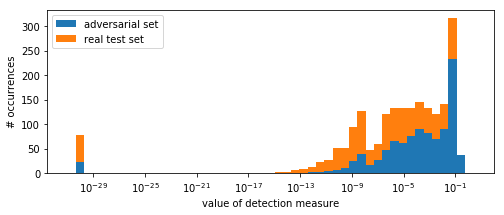

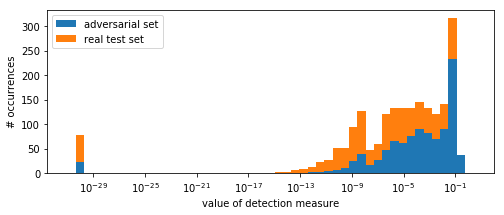

In [8]:
vis.histogram([mi_adv,mi_real],['adversarial set','real test set'],stacked=True)

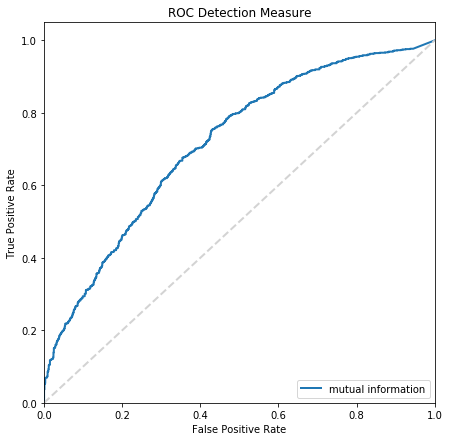

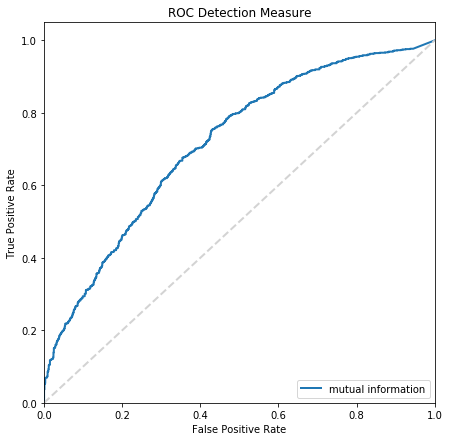

In [9]:
vis.roc([(mi_adv,mi_real)],['mutual information'])

In [13]:
from sklearn.metrics import roc_auc_score

labels = np.concatenate((np.ones(1000),np.zeros(1000)))
mi_vector = np.concatenate((mi_adv,mi_real))
roc_auc_score(labels,mi_vector)

In [14]:
np.save("mi_adv_1000",mi_adv)
np.save("mi_real_1000",mi_real)

### let's also produce some softmax variance estimates

In [15]:
sv_defense = defense.SoftmaxVariance(model,sess)
sv_adv = sv_defense(adv_subset, mc_passes=30)
sv_real = sv_defense(real_subset, mc_passes=30)

Predicted outputs with shape (1000, 30, 10) and 30 MC passes
absolute mean uncertenty 0.014660818
Predicted outputs with shape (1000, 30, 10) and 30 MC passes
absolute mean uncertenty 0.003664902


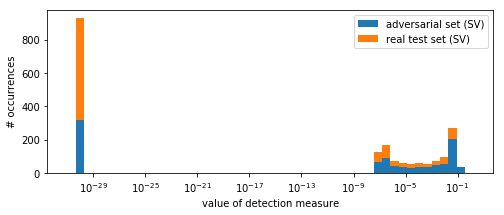

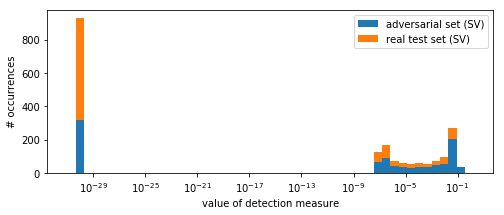

In [16]:
vis.histogram([sv_adv,sv_real],['adversarial set (SV)','real test set (SV)'],stacked=True)

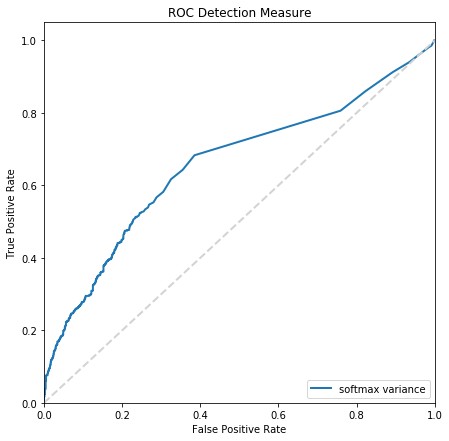

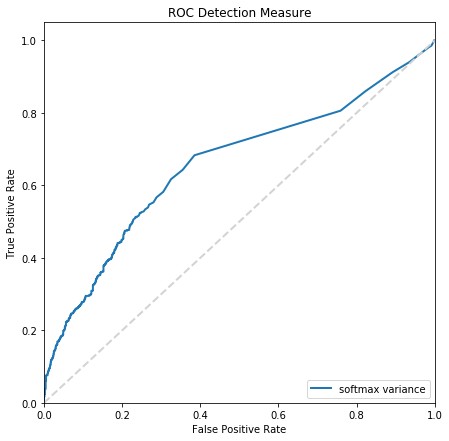

In [18]:
vis.roc([(sv_adv,sv_real)],['softmax variance'])

In [19]:
np.save("sv_adv_1000",sv_adv)
np.save("sv_real_1000",sv_real)